# Imports

In [38]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.preprocessing import OneHotEncoder
#from library.sb_utils import save_file
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_rows = 10

# Load Data

In [102]:
# the supplied CSV data files is the raw_data directory
features = pd.read_csv('../raw_data/features.csv')
stores=pd.read_csv('../raw_data/stores.csv')
train=pd.read_csv('../raw_data/train.csv')

In [40]:
features.head(2)

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True


In [233]:
stores.head(2)

,Store,Type,Size
0,1,A,151315
1,2,A,202307


In [504]:
train.head(2)

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True


# Data Wrangling

In [103]:
stores.groupby('Type')['Size'].describe()

,count,mean,std,min,25%,50%,75%,max
Type,,,,,,,,
A,22.0,177247.727273,49392.621098,39690.0,155840.75,202406.0,203819.0,219622.0
B,17.0,101190.705882,32371.137916,34875.0,93188.00,114533.0,123737.0,140167.0
C,6.0,40541.666667,1304.145033,39690.0,39745.00,39910.0,40774.0,42988.0


There are three categories of stores based on their size. Category A comprises large stores, constituting approximately half of the total. Category B consists of medium-sized stores, while Category C includes relatively small-sized stores. Generally, larger stores tend to have higher sales. It is noteworthy that the minimum values for all three categories are 30,000+, which raises some curiosity and warrants further investigation.

In [97]:
stores[stores['Type']=='A'].sort_values(by='Size').head(3)

,Store,Type,Size
32,33,A,39690
35,36,A,39910
0,1,A,151315


In [98]:
stores[stores['Type']=='B'].sort_values(by='Size').head(3)

,Store,Type,Size
4,5,B,34875
2,3,B,37392
15,16,B,57197


In [99]:
stores[stores['Type']=='C'].sort_values(by='Size',ascending=False).head(3)

,Store,Type,Size
29,30,C,42988
42,43,C,41062
36,37,C,39910


With the exception of stores 33 and 36, all stores in Type A surpass the 150,000 mark in terms of size. This suggests a potential misclassification for these two specific stores. Two stores within Type B exhibit a size below 50,000, whereas all Type C stores fall below this threshold. This leads to a reasonable inference that any store with a size less than 50,000 should be categorized as Type C.

In [100]:
#Modify the misclassificated vlaue 
condition = stores['Store'].isin([3,5,33,36])
stores['Type'] = np.where(condition, 'C',stores['Type'])

In [417]:
#merge weekly sales data with store data and features data
df=train.merge(stores,on='Store', how='inner').merge(features, on =['Store','Date'], how ='left')

In [418]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday_x   421570 non-null  bool   
 5   Type          421570 non-null  object 
 6   Size          421570 non-null  int64  
 7   Temperature   421570 non-null  float64
 8   Fuel_Price    421570 non-null  float64
 9   MarkDown1     150681 non-null  float64
 10  MarkDown2     111248 non-null  float64
 11  MarkDown3     137091 non-null  float64
 12  MarkDown4     134967 non-null  float64
 13  MarkDown5     151432 non-null  float64
 14  CPI           421570 non-null  float64
 15  Unemployment  421570 non-null  float64
 16  IsHoliday_y   421570 non-null  bool   
dtypes: bool(2), float64(10), int64(3), object(2)
mem

### Duplicate Rows And Cols

In [419]:
#check for duplicate rows
duplicate=sum(df.duplicated())
duplicate

0

There is no duplicate rows

In [420]:
#drop duplicate cols
df=df.drop('IsHoliday_y', axis=1)
df.rename(columns={'IsHoliday_x': 'IsHoliday'}, inplace=True)

### Missing Values
There are not too much missing values in this dataset, only the MarkDonw cols have missing values. MarkDonws are promotional markdowns that Walmart is running. So, it means that there is no promotion runing at that time if the MarkDown values is missing. As a result, I will fill all the missing values with 0.

In [421]:
df.fillna(0,inplace=True)

In [422]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
 5   Type          421570 non-null  object 
 6   Size          421570 non-null  int64  
 7   Temperature   421570 non-null  float64
 8   Fuel_Price    421570 non-null  float64
 9   MarkDown1     421570 non-null  float64
 10  MarkDown2     421570 non-null  float64
 11  MarkDown3     421570 non-null  float64
 12  MarkDown4     421570 non-null  float64
 13  MarkDown5     421570 non-null  float64
 14  CPI           421570 non-null  float64
 15  Unemployment  421570 non-null  float64
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 48.6+ MB


### Outliers

In [423]:
df.describe()

,Store,Dept,Weekly_Sales,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,136727.915739,60.090059,3.361027,2590.074819,879.974298,468.087665,1083.132268,1662.772385,171.201947,7.960289
std,12.785297,30.492054,22711.183519,60980.583328,18.447931,0.458515,6052.385934,5084.538801,5528.873453,3894.529945,4207.629321,39.159276,1.863296
min,1.000000,1.000000,-4988.940000,34875.000000,-2.060000,2.472000,0.000000,-265.760000,-29.100000,0.000000,0.000000,126.064000,3.879000
25%,11.000000,18.000000,2079.650000,93638.000000,46.680000,2.933000,0.000000,0.000000,0.000000,0.000000,0.000000,132.022667,6.891000
50%,22.000000,37.000000,7612.030000,140167.000000,62.090000,3.452000,0.000000,0.000000,0.000000,0.000000,0.000000,182.318780,7.866000
75%,33.000000,74.000000,20205.852500,202505.000000,74.280000,3.738000,2809.050000,2.200000,4.540000,425.290000,2168.040000,212.416993,8.572000
max,45.000000,99.000000,693099.360000,219622.000000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000


The discovery of negative minimum values for Weekly_Sales, as well as for MarkDown2 and MarkDown3, appears to be erroneous and likely the result of a typographical error. To rectify this, I will convert all negative values to their positive counterparts.

In [424]:
col_list=['Weekly_Sales','MarkDown2','MarkDown3']
df[col_list]=df[col_list].abs()

In [425]:
df.describe()

,Store,Dept,Weekly_Sales,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.676377,136727.915739,60.090059,3.361027,2590.074819,880.166251,468.098193,1083.132268,1662.772385,171.201947,7.960289
std,12.785297,30.492054,22710.889199,60980.583328,18.447931,0.458515,6052.385934,5084.505576,5528.872561,3894.529945,4207.629321,39.159276,1.863296
min,1.000000,1.000000,0.000000,34875.000000,-2.060000,2.472000,0.000000,0.000000,0.000000,0.000000,0.000000,126.064000,3.879000
25%,11.000000,18.000000,2079.757500,93638.000000,46.680000,2.933000,0.000000,0.000000,0.000000,0.000000,0.000000,132.022667,6.891000
50%,22.000000,37.000000,7612.030000,140167.000000,62.090000,3.452000,0.000000,0.000000,0.000000,0.000000,0.000000,182.318780,7.866000
75%,33.000000,74.000000,20205.852500,202505.000000,74.280000,3.738000,2809.050000,3.000000,4.540000,425.290000,2168.040000,212.416993,8.572000
max,45.000000,99.000000,693099.360000,219622.000000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000


The presence of a minimum value of 0 for Weekly_Sales indicates that certain departments in specific weeks recorded no sales. This occurrence is plausible, as it could be attributed to instances where particular departments within certain stores experienced periods of no sales for a few weeks. So I will just leave it there.

In [426]:
df[df['Weekly_Sales']==0].Dept.value_counts().head(3)

Dept
47    19
54    13
78    10
Name: count, dtype: int64

As we can see above, there are 3 departments in different stores that have more than 10 weeks did not have any sales.

# Exploratory Data Analysis

### Stores And Departments

In [427]:
print('There are ',df.Store.nunique(), ' stores in total')
print('There are ',df.Dept.nunique(), ' Departments in total')

There are  45  stores in total
There are  81  Departments in total


There are 45 stores and 81 different departments in this dataset. I will look for the relations between weekly sales and stores/departments

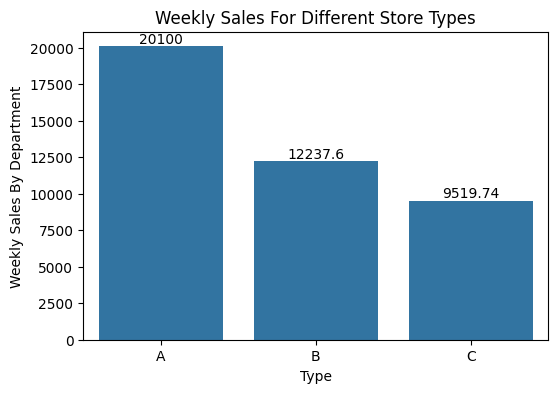

In [428]:
plt.figure(figsize=(6, 4))
ax=sns.barplot(df,x="Type",y="Weekly_Sales", errorbar=None)
ax.set_title('Weekly Sales For Different Store Types')
ax.set_ylabel('Weekly Sales By Department')
ax.bar_label(ax.containers[0], fontsize=10);

Text(0.5, 1.0, 'Weekly Sales by Store Type')

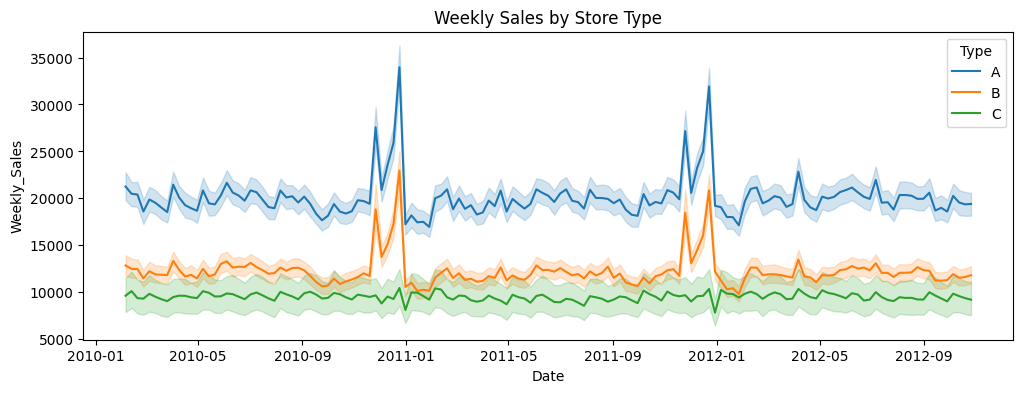

In [494]:
plt.figure(figsize=(12,4))
ax=sns.lineplot(data=df, 
             x='Date', 
             y='Weekly_Sales',
             hue='Type'
            )
ax.set_title('Weekly Sales by Store Type')

It comes as no surprise that larger stores exhibit higher weekly sales in genaral. Notably, Type A and Type B stores seem to share a similar seasonal pattern. However, Type C stores deviate slightly, with sales showing an increase during the holiday season followed by a sharp decline afterward. Moreover, the post-holiday sales for Type C stores drop significantly below the average level for the rest of the year.

Text(0, 0.5, 'Weekly Sales By Stores')

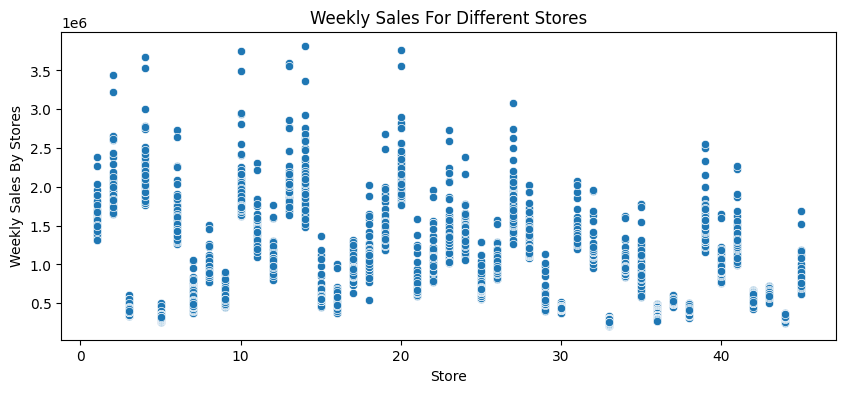

In [429]:
weekly_sales_by_store=df.groupby(['Store','Date'])['Weekly_Sales'].sum().reset_index()
plt.figure(figsize=(10, 4))
ax=sns.scatterplot(weekly_sales_by_store,x="Store",y="Weekly_Sales")
ax.set_title('Weekly Sales For Different Stores')
ax.set_ylabel('Weekly Sales By Stores')

There is evident disparity in weekly sales across various stores, with some stores displaying a more pronounced range in weekly sales volume than others. Notably, certain weeks for these stores stand out with significantly higher sales, a pattern that could be attributed to holidays or promotional events influencing these substantial spikes in sales.

Text(0.5, 1.0, 'Weekly Sales For Different Department')

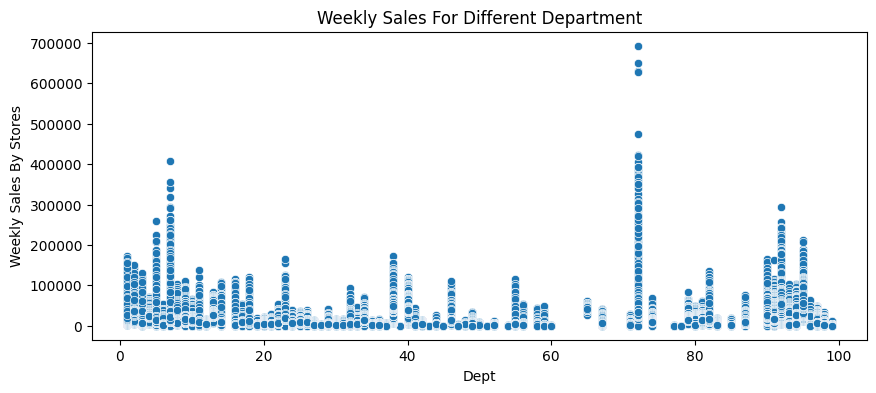

In [430]:
plt.figure(figsize=(10, 4))
ax=sns.scatterplot(df,x="Dept",y="Weekly_Sales")
ax.set_ylabel('Weekly Sales By Stores')
ax.set_title('Weekly Sales For Different Department')

The department with code 72 exhibits notably high weekly sales during specific weeks. This observation leads to the inference that the products within this department may be characterized by seasonality or increased price sensitivity, as these factors could contribute to fluctuations in sales volume.

### Holidays & Promotions
#### Holidays

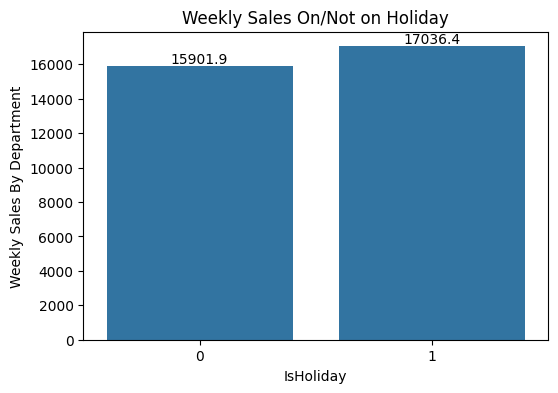

In [431]:
df['IsHoliday']=df['IsHoliday'].astype(int)
plt.figure(figsize=(6, 4))
ax=sns.barplot(df,x='IsHoliday',y='Weekly_Sales', errorbar=None)
ax.set_title('Weekly Sales On/Not on Holiday')
ax.set_ylabel('Weekly Sales By Department')
ax.bar_label(ax.containers[0], fontsize=10);

Generally, holidays tend to result in higher weekly sales by department. To ascertain which holiday, either Thanksgiving or Christmas, generates the highest sales, a detailed analysis of the data for these specific occasions is warranted.

In [432]:
df['Date']=pd.to_datetime(df['Date'])
print('The earliest Date is: ',df.Date.min())
print('The latest Date is: ',df.Date.max())

The earliest Date is:  2010-02-05 00:00:00
The latest Date is:  2012-10-26 00:00:00


In [433]:
#Check for Holidays in this dataset
df[df['IsHoliday']==1].Date.unique()

<DatetimeArray>
['2010-02-12 00:00:00', '2010-09-10 00:00:00', '2010-11-26 00:00:00',
 '2010-12-31 00:00:00', '2011-02-11 00:00:00', '2011-09-09 00:00:00',
 '2011-11-25 00:00:00', '2011-12-30 00:00:00', '2012-02-10 00:00:00',
 '2012-09-07 00:00:00']
Length: 10, dtype: datetime64[ns]

In [434]:
#Find out what holidays are these dates
from datetime import date 
import holidays 
for hd in holidays.US(years = 2010).items(): 
    print(hd) 

(datetime.date(2010, 1, 18), 'Martin Luther King Jr. Day')
(datetime.date(2010, 2, 15), "Washington's Birthday")
(datetime.date(2010, 10, 11), 'Columbus Day')
(datetime.date(2010, 1, 1), "New Year's Day")
(datetime.date(2010, 12, 31), "New Year's Day (Observed)")
(datetime.date(2010, 5, 31), 'Memorial Day')
(datetime.date(2010, 7, 4), 'Independence Day')
(datetime.date(2010, 7, 5), 'Independence Day (Observed)')
(datetime.date(2010, 9, 6), 'Labor Day')
(datetime.date(2010, 11, 11), 'Veterans Day')
(datetime.date(2010, 11, 25), 'Thanksgiving')
(datetime.date(2010, 12, 25), 'Christmas Day')
(datetime.date(2010, 12, 24), 'Christmas Day (Observed)')


2010-09-10,2011-09-09,2012-09-07 are Labor Day weeks. 2010-11-26,2011-11-25 are Thanksgiving weeks. 2010-12-31,2011-12-30 are Christmas weeks. Then how about 2010-02-12,2011-02-11 and 2012-02-10? After google I find all these weeks are the week that Super Bowl held. Certainly, based on the provided information, it appears that Walmart has identified four significant holidays in the dataset that could potentially impact their sales. Due to the lack of geographical information and the varying dates for tax-free weekends across states, we won't be incorporating the potential impact of these events on sales in this project. 

In [435]:
#Create new features to denote the 4 holidays.
date_list1=pd.to_datetime(['2010-02-12','2011-02-11', '2012-02-10'])
df['Super_Bowl']=df['Date'].isin(date_list1).astype(int)

date_list2=pd.to_datetime(['2010-09-10','2011-09-09','2012-09-07'])
df['Labor_Day']=df['Date'].isin(date_list2).astype(int)

date_list3=pd.to_datetime(['2010-11-26','2011-11-25'])
df['Thanksgiving']=df['Date'].isin(date_list3).astype(int)

date_list4=pd.to_datetime(['2010-12-31','2011-12-30'])
df['Christmas']=df['Date'].isin(date_list4).astype(int)

[Text(0, 0, '16002.2'), Text(0, 0, '14544.8')]

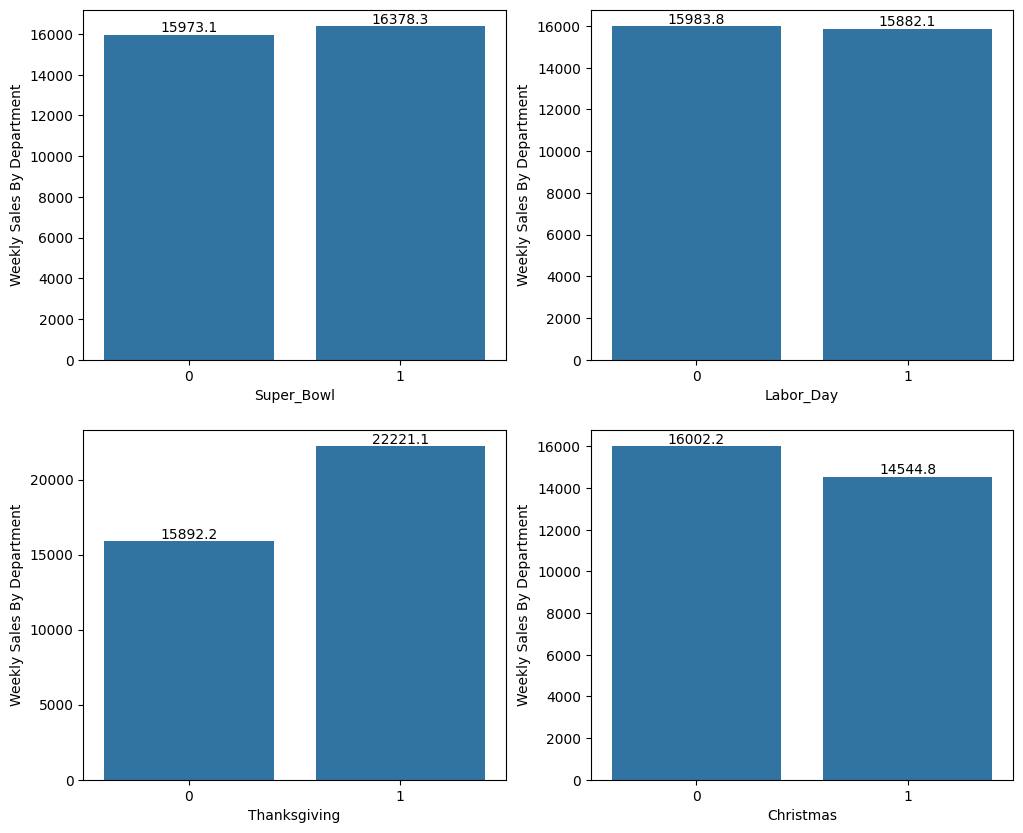

In [487]:
plt.rcParams['figure.figsize'] = (12, 10)
plt.subplot(221)
ax=sns.barplot(df,x='Super_Bowl',y='Weekly_Sales', errorbar=None)
ax.set_ylabel('Weekly Sales By Department')
ax.bar_label(ax.containers[0])

plt.subplot(222)
ax=sns.barplot(df,x='Labor_Day',y='Weekly_Sales', errorbar=None)
ax.set_ylabel('Weekly Sales By Department')
ax.bar_label(ax.containers[0])

plt.subplot(223)
ax=sns.barplot(df,x='Thanksgiving',y='Weekly_Sales', errorbar=None)
ax.set_ylabel('Weekly Sales By Department')
ax.bar_label(ax.containers[0])

plt.subplot(224)
ax=sns.barplot(df,x='Christmas',y='Weekly_Sales', errorbar=None)
ax.set_ylabel('Weekly Sales By Department')
ax.bar_label(ax.containers[0])

It appears that Labor Day has negligible influence on sales, with Super Bowl having only a minor impact. In contrast, Thanksgiving and Christmas exhibit substantial impacts on sales, particularly during Thanksgiving week, where the weekly sales experience a significant surge.

#### Promotions

In [ ]:
#Markdown1 vs Weekly Sales
M=df.groupby(['Date','Store','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'])['Weekly_Sales'].sum().reset_index()

In [ ]:
#Take Store 17 as an example
plt.rcParams['figure.figsize'] = (12, 12)
plt.subplot(511)
ax=sns.scatterplot(M[M['Store']==17],x="Date",y="Weekly_Sales", hue='MarkDown1',size='MarkDown1',sizes=(50, 200), palette='viridis')
ax.set_ylabel('Weekly Sales For Stores17')
ax.set_title('MarkDowns VS. Weekly Sales for Store 17')

plt.subplot(512)
ax=sns.scatterplot(M[M['Store']==17],x="Date",y="Weekly_Sales", hue='MarkDown2',size='MarkDown2',sizes=(50, 200), palette='viridis')
ax.set_ylabel('Weekly Sales For Stores17')

plt.subplot(513)
ax=sns.scatterplot(M[M['Store']==17],x="Date",y="Weekly_Sales", hue='MarkDown3',size='MarkDown3',sizes=(50, 200), palette='viridis')
ax.set_ylabel('Weekly Sales For Stores17')

plt.subplot(514)
ax=sns.scatterplot(M[M['Store']==17],x="Date",y="Weekly_Sales", hue='MarkDown4',size='MarkDown4',sizes=(50, 200), palette='viridis')
ax.set_ylabel('Weekly Sales For Stores17')

plt.subplot(515)
ax=sns.scatterplot(M[M['Store']==17],x="Date",y="Weekly_Sales", hue='MarkDown5',size='MarkDown5',sizes=(50, 200), palette='viridis')
ax.set_ylabel('Weekly Sales For Stores17')

Generally, promotions tend to boost sales. However, for store 17, it appears that most promotions occurred after November 2011. To determine whether this trend is consistent across all stores or specific to store 17, further investigation is needed.

In [ ]:
M[(M.iloc[:,2:6]>0).any(axis=1)].Date.min()

It's noteworthy that the promotion data for all stores commenced after November 11, 2011. This could potentially pose a challenge if we lack data prior to this date when utilizing these features in our model. Despite this concern, you've decided to retain these features for the time being.

### Temperature, Fuel_Price, CPI, Unemployment
#### Temperature

In [ ]:
print('The highest Temperature is ', df.Temperature.max())
print('The lowest Temperature is ', df.Temperature.min())

In [ ]:
T=df.groupby(['Date','Store','Temperature'])['Weekly_Sales'].sum().reset_index()

In [ ]:
#Take Store 1,17 as an example
plt.rcParams['figure.figsize'] = (12, 6)
plt.subplots_adjust(hspace=0.5)
plt.subplot(211)
ax=sns.scatterplot(T[T['Store']==1],x="Date",y="Weekly_Sales", hue='Temperature',size='Temperature',sizes=(50, 200), palette='viridis')
ax.set_ylabel('Weekly Sales For Stores1')
ax.set_title('Temperature VS. Weekly Sales for Store 1')

plt.subplot(212)
ax=sns.scatterplot(T[T['Store']==17],x="Date",y="Weekly_Sales", hue='Temperature',size='Temperature',sizes=(50, 200), palette='viridis')
ax.set_ylabel('Weekly Sales For Stores17')
ax.set_title('Temperature VS. Weekly Sales for Store 17')

The observed pattern for these two stores suggests a more pronounced seasonal trend, with temperature appearing to have a relatively minor impact on sales.

#### Fuel Price

In [ ]:
print('The highest Fuel Price is ', df.Fuel_Price.max())
print('The lowest Fuel Price is ', df.Fuel_Price.min())

In [ ]:
#For this analysis, we will take the avg store weekly sales and the weely avg fuel price for a store.
F=df.groupby(['Date','Store','Fuel_Price'])['Weekly_Sales'].sum().reset_index()
F=F.groupby(['Date']).mean().reset_index().rename(columns={'Fuel_Price': 'Mean_Fuel_Price', 'Weekly_Sales': 'Mean_Weekly_Sales'})

In [ ]:
plt.rcParams['figure.figsize'] = (12, 2)
ax=sns.scatterplot(F,x="Date",y="Mean_Weekly_Sales", hue='Mean_Fuel_Price',size='Mean_Fuel_Price',sizes=(50, 200), palette='viridis')
ax.set_title('Average Weekly Sales Vs Average Fuel Price')
ax.set_ylabel('Average Weekly Sales')

Despite a noticeable surge in fuel prices from 2011 onwards, there doesn't seem to be any apparent evidence indicating a correlation between weekly sales and fuel prices.

#### CPI & Unemployment

In [ ]:
print('The highest CPI is ', df.CPI.max())
print('The lowest CPI is ', df.CPI.min())

Typically, a higher Consumer Price Index (CPI) suggests that consumer prices are on the rise. And a higher Unemployment rate means people have less money. This inference leads to the assumption that people may be less inclined to consume due to the impact of high inflation and high unemploymen.

In [ ]:
C=df.groupby(['Date','Store','CPI'])['Weekly_Sales'].sum().reset_index()

In [ ]:
#Take Store 1,17 as an example
plt.rcParams['figure.figsize'] = (12, 6)
plt.subplots_adjust(hspace=0.5)
plt.subplot(211)
ax=sns.scatterplot(C[C['Store']==1],x="Date",y='CPI', hue="Weekly_Sales",size="Weekly_Sales",sizes=(50, 200), palette='viridis')
ax.set_ylabel('CPI')
ax.set_title('CPI VS. Weekly Sales for Store 1')

plt.subplot(212)
ax=sns.scatterplot(C[C['Store']==17],x="Date",y='CPI', hue="Weekly_Sales",size="Weekly_Sales",sizes=(50, 200), palette='viridis')
ax.set_ylabel('CPI')
ax.set_title('CPI VS. Weekly Sales for Store 17')

Similar to the fuel price trend, despite an increase in the Consumer Price Index (CPI) since 2011, the store weekly sales continue to exhibit a seasonal pattern, and there appears to be less correlation with the CPI.

In [437]:
print('The highest Unemployment is ', df.Unemployment.max())
print('The lowest Unemployment is ', df.Unemployment.min())
U=df.groupby(['Date','Store','Unemployment'])['Weekly_Sales'].sum().reset_index()

The highest Unemployment is  14.313
The lowest Unemployment is  3.879


In [438]:
U[U['Unemployment']==U['Unemployment'].min()]

,Date,Store,Unemployment,Weekly_Sales
6258,2012-10-05,4,3.879,2209835.43
6303,2012-10-12,4,3.879,2133026.07
6348,2012-10-19,4,3.879,2097266.85
6393,2012-10-26,4,3.879,2149594.46


In [439]:
U[U['Unemployment']==U['Unemployment'].max()].head()

,Date,Store,Unemployment,Weekly_Sales
1541,2010-10-01,12,14.313,850936.26
1557,2010-10-01,28,14.313,1203080.41
1567,2010-10-01,38,14.313,360256.58
1586,2010-10-08,12,14.313,918335.68
1602,2010-10-08,28,14.313,1344549.75


Text(0.5, 1.0, 'Weekly Sales by Store VS. Unemployment for Store 12')

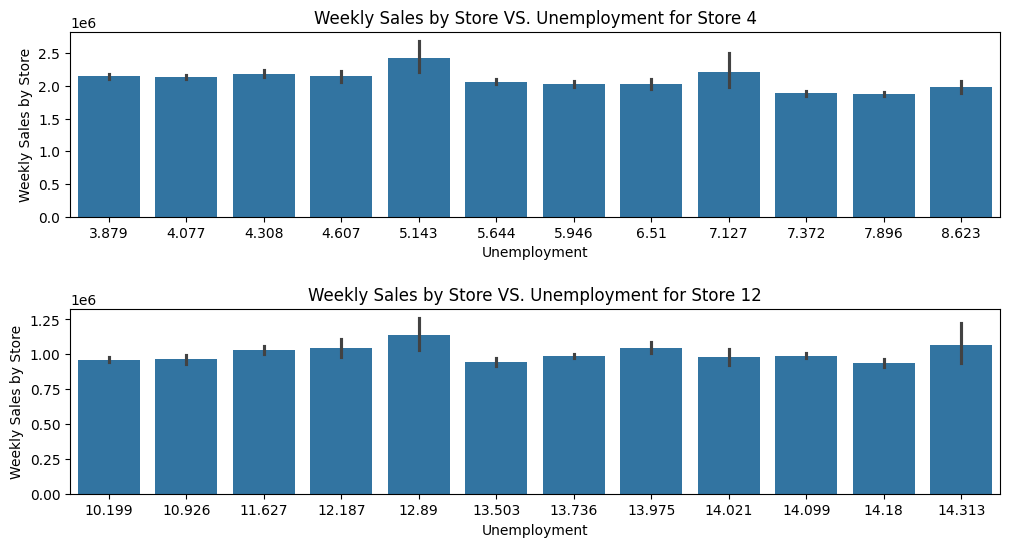

In [440]:
#Take Store 4,12 as an example(The store that have the highest Unemployment and lowest unemployment rate)
plt.rcParams['figure.figsize'] = (12, 6)
plt.subplots_adjust(hspace=0.5)
plt.subplot(211)
ax=sns.barplot(U[U['Store']==4],x="Unemployment",y='Weekly_Sales')
ax.set_ylabel('Weekly Sales by Store')
ax.set_title('Weekly Sales by Store VS. Unemployment for Store 4')

plt.subplot(212)
ax=sns.barplot(U[U['Store']==12],x="Unemployment",y='Weekly_Sales')
ax.set_ylabel('Weekly Sales by Store')
ax.set_title('Weekly Sales by Store VS. Unemployment for Store 12')

There is still a lack of evidence indicating any influence of the unemployment rate on weekly sales. The data does not suggest a clear correlation between these two variables.

### Weekly Sales

We've already observed certain seasonal patterns in our previous analysis. Now, let's delve into a direct examination of the Weekly Sales data over time to uncover these inherent seasonal patterns. This analysis aims to provide insights into trends, fluctuations, and potential peaks associated with sales across various dates in the dataset.

In [442]:
df.set_index('Date',inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 421570 entries, 2010-02-05 to 2012-10-26
Data columns (total 19 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Weekly_Sales  421570 non-null  float64
 3   IsHoliday     421570 non-null  int64  
 4   Type          421570 non-null  object 
 5   Size          421570 non-null  int64  
 6   Temperature   421570 non-null  float64
 7   Fuel_Price    421570 non-null  float64
 8   MarkDown1     421570 non-null  float64
 9   MarkDown2     421570 non-null  float64
 10  MarkDown3     421570 non-null  float64
 11  MarkDown4     421570 non-null  float64
 12  MarkDown5     421570 non-null  float64
 13  CPI           421570 non-null  float64
 14  Unemployment  421570 non-null  float64
 15  Super_Bowl    421570 non-null  int64  
 16  Labor_Day     421570 non-null  int64  
 17  Thanksgiving  421570 non-null  i

In [454]:
#Weekly sales by department
df_w = df.drop('Type',axis=1).resample('W').mean()

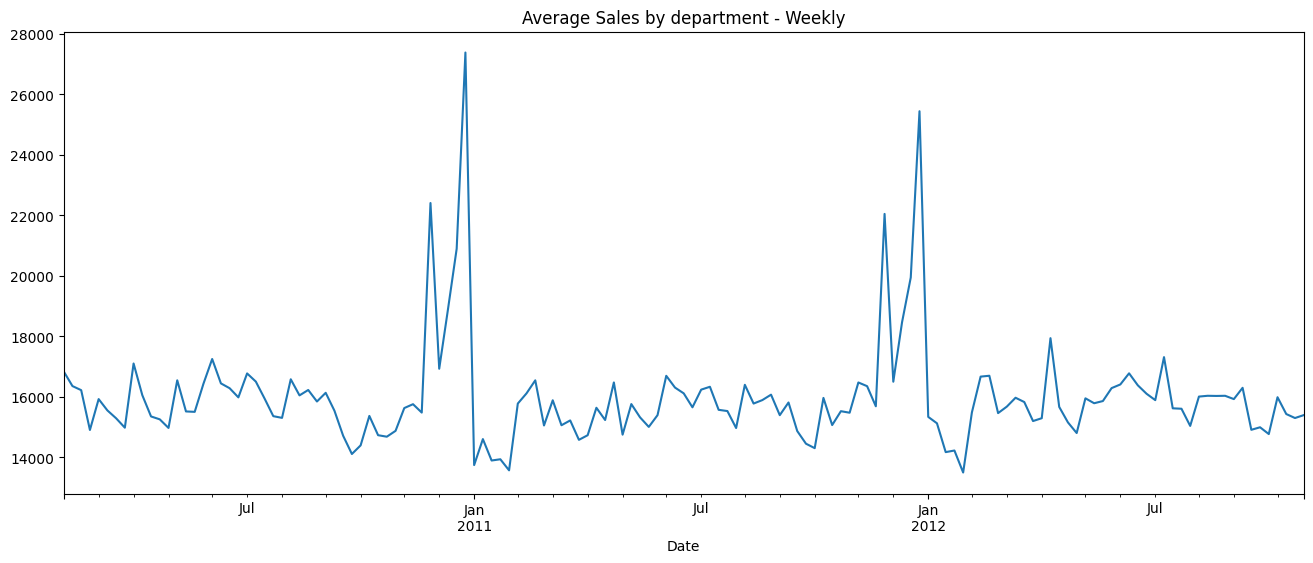

In [455]:
#plot the weekly sales through time
plt.figure(figsize=(16,6))
df_w['Weekly_Sales'].plot()
plt.title('Average Sales by department - Weekly')
plt.show()

<Figure size 1200x600 with 0 Axes>

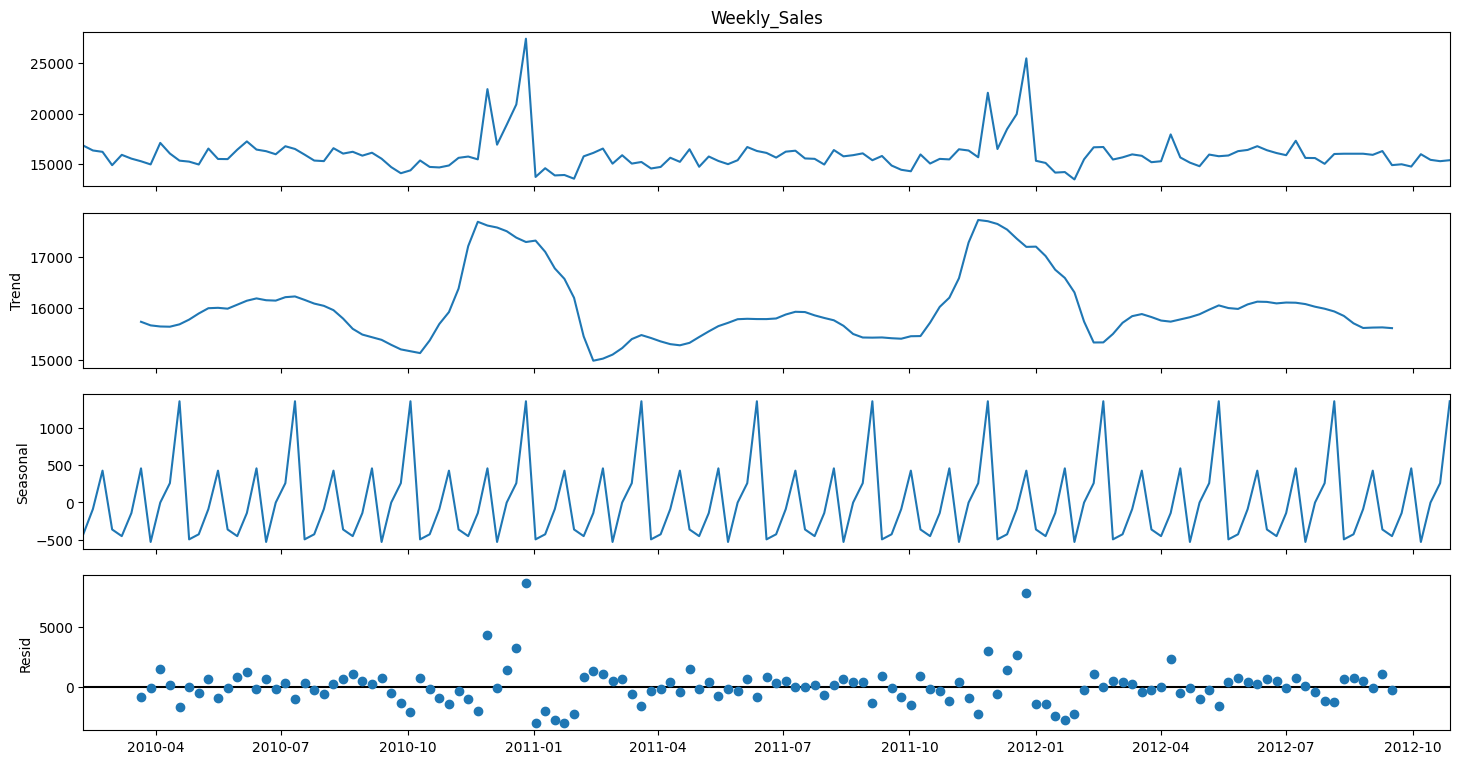

In [480]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df_w.Weekly_Sales,model='additive',period=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

It's clearly that there was a seasonal patten for the weekly sales. The presence of a clear seasonal pattern in weekly sales prompts the decision to resample the data into monthly, quarterly, and yearly intervals. This step aims to explore potential patterns at different temporal resolutions beyond the weekly level.

In [498]:
#df['Week']=df.index.week
df['Month'] = df.index.month
df['Quarter'] = df.index.quarter
df['Year'] = df.index.year

In [485]:
df.head()

,Store,Dept,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,...,MarkDown5,CPI,Unemployment,Super_Bowl,Labor_Day,Thanksgiving,Christmas,Month,Quarter,Year
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-05,1,1,24924.50,0,A,151315,42.31,2.572,0.0,0.0,...,0.0,211.096358,8.106,0,0,0,0,2,1,2010
2010-02-12,1,1,46039.49,1,A,151315,38.51,2.548,0.0,0.0,...,0.0,211.242170,8.106,1,0,0,0,2,1,2010
2010-02-19,1,1,41595.55,0,A,151315,39.93,2.514,0.0,0.0,...,0.0,211.289143,8.106,0,0,0,0,2,1,2010
2010-02-26,1,1,19403.54,0,A,151315,46.63,2.561,0.0,0.0,...,0.0,211.319643,8.106,0,0,0,0,2,1,2010
2010-03-05,1,1,21827.90,0,A,151315,46.50,2.625,0.0,0.0,...,0.0,211.350143,8.106,0,0,0,0,3,1,2010


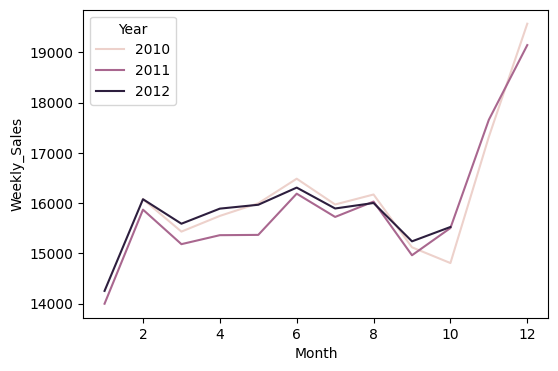

In [491]:
# line plot showing the trend of the weekly sales mean by month
plt.figure(figsize=(6, 4))
ax = sns.lineplot(
    df, x='Month', y='Weekly_Sales',
    hue='Year',
    estimator='mean', 
    errorbar=None,
)
ax.set_title('Average Weekly Sales by Month')

Text(0.5, 1.0, 'Average Weekly Sales by Quarter')

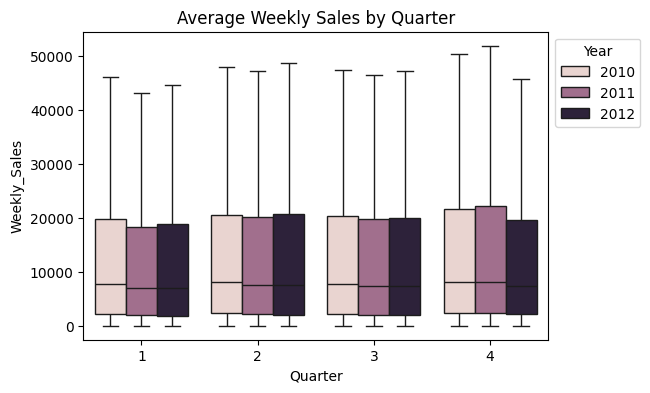

In [502]:
# line plot showing the trend of the weekly sales mean by quarter
plt.figure(figsize=(6, 4))
ax = sns.boxplot(
    df, x='Quarter', y='Weekly_Sales',
    hue='Year', 
    showfliers=False
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_title('Average Weekly Sales by Quarter')

Quarter 4 consistently exhibits higher weekly sales for the years 2010 and 2011, aligning with the holiday season. However, in 2012, weekly sales in Quarter 4 decline. This decline may be attributed to the lack of data after 10/26/2012, excluding holidays like Thanksgiving and Christmas. A reasonable inference is that people tend to delay their shopping before these holidays, anticipating promotions, which could explain the drop in weekly sales during the initial month of Quarter 4.

# Save Data

In [505]:
df.to_csv('clean_data.csv')

# Summary


The analysis of store data reveals three store types based on size: Type A (large), Type B (medium), and Type C (small). However, anomalies in store sizes and weekly sales suggest potential misclassifications. Notably, some Type B and Type A stores have sizes less than 50k, prompting a reasonable inference that such stores should be categorized as Type C. Larger stores consistently have higher sales, and Type C stores exhibit a distinct pattern, with sales dropping sharply post-holidays.

Investigating weekly sales patterns, it is observed that holidays, specifically Thanksgiving and Christmas, significantly impact sales. Some departments show spikes in sales during specific weeks, such as Super Bowl weeks.

The impact of promotions on sales is examined. Negative minimum values for weekly sales and markdowns are identified as potential typos and corrected to positive values. While promotions generally boost sales, it is noted that promotion data for all stores starts after November 11, 2011. Despite concerns about missing data, these features are retained for further analysis.

Seasonal patterns in store sales are identified, with temperature and CPI showing less correlation with sales. Fuel prices, despite rising, do not exhibit a clear correlation with weekly sales. Unemployment rates also do not appear to influence sales.

Further exploration involves analyzing weekly sales over time, revealing clear seasonal patterns. Resampling the data into monthly, quarterly, and yearly intervals provides insights into different temporal resolutions.

Quarter 4 consistently shows higher weekly sales for 2010 and 2011, aligning with the holiday season. However, a decline in 2012 could be attributed to the lack of data after 10/26/2012, suggesting that people might delay shopping before Thanksgiving and Christmas, anticipating promotions.

In summary, the analysis uncovers store classifications, seasonal sales patterns, and the impact of holidays on sales. Challenges such as potential misclassifications and missing data are noted, providing a foundation for further investigation and modeling.